In [4]:
#python3 -m notebook
import os 
os.environ['CUDA_VISIBLE_DEVICES']='1'
%pylab inline
from tqdm import tqdm


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Fitting kernel at 64**3 particles resolution

In [6]:
import jax_cosmo as jc

mesh_shape= [64, 64, 64]
box_size  = [25., 25., 25.]
cosmo = jc.Planck15(Omega_c= 0.3 - 0.049, Omega_b=0.049, n_s=0.9624, h=0.6711, sigma8=0.8)

In [7]:
#export PYTHONPATH="$PYTHONPATH//home/george/CAMELS/library/build/lib"
# import sys
# sys.path.append('home/george/CAMELS/library/build/lib')
#import camels_library as cl
import readgadget
import numpy as np

init_cond = 'CV_0/ICs/ics'

header   = readgadget.header(init_cond)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

ptype = [1] #dark matter is particle type 1
ids_i = np.argsort(readgadget.read_block(init_cond, "ID  ", ptype)-1)  #IDs starting from 0
pos_i = readgadget.read_block(init_cond, "POS ", ptype)[ids_i]/1e3     #positions in Mpc/h
vel_i = readgadget.read_block(init_cond, "VEL ", ptype)[ids_i]         #peculiar velocities in km/s

# Reordering data for simple reshaping
pos_i = pos_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
vel_i = vel_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
pos_i = (pos_i/BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
vel_i = (vel_i / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
a_i   = 1./(1+redshift)

In [8]:
scales = []
poss = []
vels = []

# Loading all the intermediate snapshots
for i in tqdm(range(34)):
    snapshot='CV_0/snap_%03d.hdf5'%i
    
    header   = readgadget.header(snapshot)
    
    redshift = header.redshift     #redshift of the snapshot
    h        = header.hubble       #value of h
    
    ptype = [1] #dark matter is particle type 1
    ids = np.argsort(readgadget.read_block(snapshot, "ID  ", ptype)-1)   #IDs starting from 0
    pos = readgadget.read_block(snapshot, "POS ", ptype)[ids]/1e3        #positions in Mpc/h
    vel = readgadget.read_block(snapshot, "VEL ", ptype)[ids]            #peculiar velocities in km/s

    # Reordering data for simple reshaping
    pos = pos.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    vel = vel.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    
    pos = (pos / BoxSize * 64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    vel = (vel / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    
    scales.append((1./(1+redshift)))
    poss.append(pos)
    vels.append(vel)

100%|██████████| 34/34 [03:42<00:00,  6.54s/it]


In [9]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import haiku as hk

from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, laplace_kernel, longrange_kernel
from jaxpm.nn import NeuralSplineFourierFilter
from jaxpm.utils import power_spectrum

rng_seq = hk.PRNGSequence(1)

In [10]:
# Run the reference simulation without correction at the same steps
resi = odeint(make_ode_fn(mesh_shape), [poss[0], vels[0]], jnp.array(scales), cosmo, rtol=1e-5, atol=1e-5)

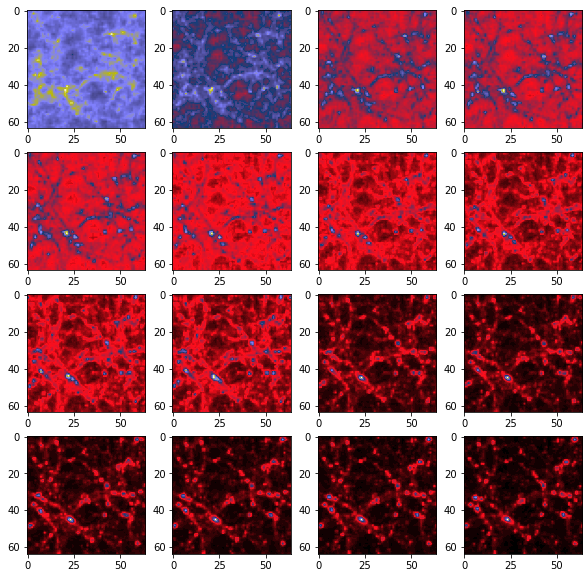

In [11]:
# High res simulation
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0), cmap='gist_stern', vmin=0)

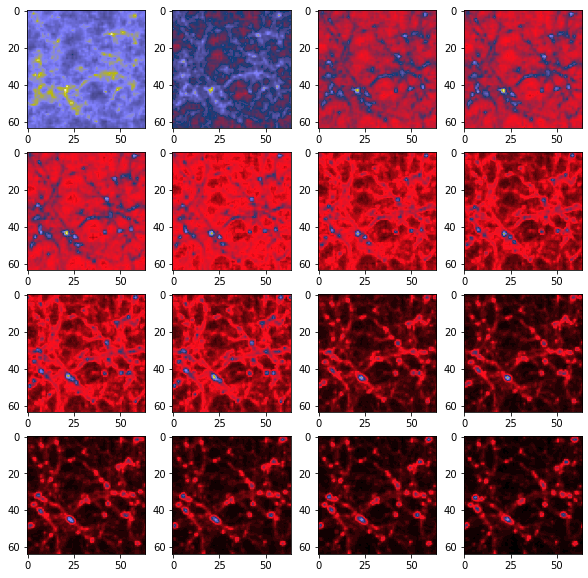

In [12]:
# JaxPM without correction
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [13]:
k, pk_ref = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

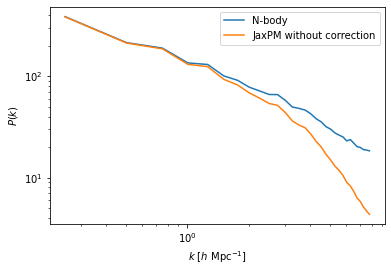

In [14]:
loglog(k,pk_ref, label='N-body')
loglog(k,pk_i, label='JaxPM without correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

In [15]:
# Instantiate the neural network
# model = hk.without_apply_rng(hk.transform(lambda x,a : NeuralSplineFourierFilter()(x,a)))

# params = model.init(next(rng_seq), jnp.zeros([64]), jnp.ones([1]))

In [17]:
from  Net3d import*



# Instantiate the neural network

model = hk.without_apply_rng(hk.transform(lambda x : SpectralConv3()(x)))

params = model.init(next(rng_seq),jnp.zeros((64,64,33)))

In [18]:
def neural_nbody_ode(state, a, cosmo, params):
    """
    state is a tuple (position, velocities)
    """
    pos, vel = state
    
    kvec = fftk(mesh_shape)

    delta = cic_paint(jnp.zeros(mesh_shape), pos)
    
    delta_k = jnp.fft.rfftn(delta)
    
    # Computes gravitational potential
    pot_k = delta_k * laplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)
    
    # Apply a correction filter
    kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))
    pot_k = pot_k + model.apply(params, pot_k)
    #print(model.apply(params, kk, jnp.atleast_1d(a)))
    # Computes gravitational forces
    forces = jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k), pos) 
                      for i in range(3)],axis=-1)
    
    forces = forces * 1.5 * cosmo.Omega_m

    # Computes the update of position (drift)
    dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel
    
    # Computes the update of velocity (kick)
    dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces
    
    return dpos, dvel

In [19]:
ref_pos = jnp.stack(poss, axis=0)
ref_vel = jnp.stack(vels, axis=0)

@jax.jit
def loss_fn(params):
  res = odeint(neural_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, params, rtol=1e-5, atol=1e-5) 
  distance = jnp.sum((res[0] - ref_pos)**2, axis=-1)
  w = jnp.where(distance < 100, distance, 0.)
  # Optional lines to include velocity in the loss
  vel = jnp.sum((res[1] - ref_vel)**2, axis=-1)
  wv = jnp.where(distance < 100, vel, 0.)
  return 0.01*jnp.mean(wv) + jnp.mean(w)

@jax.jit
def update(params, opt_state):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

In [20]:
losses = []
import optax
lr_fun= optax.cosine_decay_schedule(0.01, 1000 , alpha=0.0)
#learning_rate=0.001
optimizer = optax.adam(lr_fun)
opt_state = optimizer.init(params)

In [21]:
for step in tqdm(range(10000)):
  l, params, opt_state = update(params, opt_state)
  if(step%10==0):
    print("Step: ", step, " Loss: ",l)
  losses.append(l)

  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_3022964/3478237513.py:17: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))
/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/ops/scatter.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)
2022-05-15 19:30:02.895291: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:61] Constant folding an instruction is taking > 1s:

  %negate.67 = f32[34,262144,3]{2,1,0} negate(f32[34,262144,3]{2,1,0} %constant.43)

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking 

Step:  0  Loss:  9.606716


  0%|          | 11/10000 [00:39<4:18:14,  1.55s/it]

Step:  10  Loss:  7.8043633


  0%|          | 21/10000 [00:52<3:41:28,  1.33s/it]

Step:  20  Loss:  6.1515565


  0%|          | 31/10000 [01:05<3:39:24,  1.32s/it]

Step:  30  Loss:  4.805139


  0%|          | 41/10000 [01:18<3:38:55,  1.32s/it]

Step:  40  Loss:  3.7550585


  1%|          | 51/10000 [01:32<3:37:10,  1.31s/it]

Step:  50  Loss:  2.9472542


  1%|          | 61/10000 [01:45<3:36:56,  1.31s/it]

Step:  60  Loss:  2.3605607


  1%|          | 71/10000 [01:58<3:37:02,  1.31s/it]

Step:  70  Loss:  1.9263527


  1%|          | 81/10000 [02:11<3:36:51,  1.31s/it]

Step:  80  Loss:  1.5990974


  1%|          | 91/10000 [02:24<3:35:28,  1.30s/it]

Step:  90  Loss:  1.3519192


  1%|          | 101/10000 [02:37<3:34:33,  1.30s/it]

Step:  100  Loss:  1.1632985


  1%|          | 111/10000 [02:50<3:33:07,  1.29s/it]

Step:  110  Loss:  1.0170622


  1%|          | 121/10000 [03:03<3:32:46,  1.29s/it]

Step:  120  Loss:  0.90473396


  1%|▏         | 131/10000 [03:16<3:32:41,  1.29s/it]

Step:  130  Loss:  0.8172499


  1%|▏         | 141/10000 [03:29<3:31:51,  1.29s/it]

Step:  140  Loss:  0.7475468


  2%|▏         | 151/10000 [03:42<3:31:41,  1.29s/it]

Step:  150  Loss:  0.68986684


  2%|▏         | 161/10000 [03:54<3:31:31,  1.29s/it]

Step:  160  Loss:  0.63958514


  2%|▏         | 171/10000 [04:07<3:30:26,  1.28s/it]

Step:  170  Loss:  0.6015913


  2%|▏         | 181/10000 [04:20<3:30:49,  1.29s/it]

Step:  180  Loss:  0.571153


  2%|▏         | 191/10000 [04:33<3:30:53,  1.29s/it]

Step:  190  Loss:  0.5459073


  2%|▏         | 201/10000 [04:46<3:29:43,  1.28s/it]

Step:  200  Loss:  0.5246266


  2%|▏         | 211/10000 [04:59<3:29:22,  1.28s/it]

Step:  210  Loss:  0.50652087


  2%|▏         | 221/10000 [05:12<3:29:38,  1.29s/it]

Step:  220  Loss:  0.49090937


  2%|▏         | 231/10000 [05:24<3:28:31,  1.28s/it]

Step:  230  Loss:  0.47744864


  2%|▏         | 241/10000 [05:37<3:29:14,  1.29s/it]

Step:  240  Loss:  0.46574137


  3%|▎         | 251/10000 [05:50<3:27:05,  1.27s/it]

Step:  250  Loss:  0.4555397


  3%|▎         | 261/10000 [06:03<3:27:47,  1.28s/it]

Step:  260  Loss:  0.4468502


  3%|▎         | 271/10000 [06:16<3:27:59,  1.28s/it]

Step:  270  Loss:  0.43937445


  3%|▎         | 281/10000 [06:28<3:27:42,  1.28s/it]

Step:  280  Loss:  0.4328164


  3%|▎         | 291/10000 [06:41<3:27:31,  1.28s/it]

Step:  290  Loss:  0.42702296


  3%|▎         | 301/10000 [06:54<3:25:55,  1.27s/it]

Step:  300  Loss:  0.4218481


  3%|▎         | 311/10000 [07:07<3:26:11,  1.28s/it]

Step:  310  Loss:  0.4171702


  3%|▎         | 321/10000 [07:20<3:26:46,  1.28s/it]

Step:  320  Loss:  0.41296774


  3%|▎         | 331/10000 [07:32<3:25:50,  1.28s/it]

Step:  330  Loss:  0.4091791


  3%|▎         | 341/10000 [07:45<3:26:22,  1.28s/it]

Step:  340  Loss:  0.4057392


  4%|▎         | 351/10000 [07:58<3:25:43,  1.28s/it]

Step:  350  Loss:  0.40260807


  4%|▎         | 361/10000 [08:11<3:25:42,  1.28s/it]

Step:  360  Loss:  0.3997584


  4%|▎         | 371/10000 [08:24<3:25:47,  1.28s/it]

Step:  370  Loss:  0.39714977


  4%|▍         | 381/10000 [08:36<3:25:28,  1.28s/it]

Step:  380  Loss:  0.394724


  4%|▍         | 391/10000 [08:49<3:23:52,  1.27s/it]

Step:  390  Loss:  0.3924774


  4%|▍         | 401/10000 [09:02<3:23:40,  1.27s/it]

Step:  400  Loss:  0.39040235


  4%|▍         | 411/10000 [09:15<3:24:13,  1.28s/it]

Step:  410  Loss:  0.3884857


  4%|▍         | 421/10000 [09:27<3:23:38,  1.28s/it]

Step:  420  Loss:  0.38671514


  4%|▍         | 431/10000 [09:40<3:23:48,  1.28s/it]

Step:  430  Loss:  0.38507202


  4%|▍         | 441/10000 [09:53<3:22:52,  1.27s/it]

Step:  440  Loss:  0.3835404


  5%|▍         | 451/10000 [10:06<3:22:42,  1.27s/it]

Step:  450  Loss:  0.38211694


  5%|▍         | 461/10000 [10:18<3:22:17,  1.27s/it]

Step:  460  Loss:  0.3807876


  5%|▍         | 471/10000 [10:31<3:22:12,  1.27s/it]

Step:  470  Loss:  0.3795472


  5%|▍         | 481/10000 [10:44<3:23:15,  1.28s/it]

Step:  480  Loss:  0.378403


  5%|▍         | 491/10000 [10:57<3:23:08,  1.28s/it]

Step:  490  Loss:  0.37732288


  5%|▌         | 501/10000 [11:10<3:22:58,  1.28s/it]

Step:  500  Loss:  0.37631243


  5%|▌         | 511/10000 [11:22<3:22:48,  1.28s/it]

Step:  510  Loss:  0.37536663


  5%|▌         | 521/10000 [11:35<3:22:35,  1.28s/it]

Step:  520  Loss:  0.37447894


  5%|▌         | 531/10000 [11:48<3:21:38,  1.28s/it]

Step:  530  Loss:  0.37364405


  5%|▌         | 541/10000 [12:01<3:20:45,  1.27s/it]

Step:  540  Loss:  0.3728574


  6%|▌         | 551/10000 [12:13<3:21:25,  1.28s/it]

Step:  550  Loss:  0.37211716


  6%|▌         | 561/10000 [12:26<3:21:36,  1.28s/it]

Step:  560  Loss:  0.37142217


  6%|▌         | 571/10000 [12:39<3:21:27,  1.28s/it]

Step:  570  Loss:  0.3707697


  6%|▌         | 581/10000 [12:52<3:20:28,  1.28s/it]

Step:  580  Loss:  0.37015626


  6%|▌         | 591/10000 [13:05<3:21:27,  1.28s/it]

Step:  590  Loss:  0.3695798


  6%|▌         | 601/10000 [13:18<3:21:24,  1.29s/it]

Step:  600  Loss:  0.36903888


  6%|▌         | 611/10000 [13:30<3:21:17,  1.29s/it]

Step:  610  Loss:  0.3685301


  6%|▌         | 621/10000 [13:43<3:21:04,  1.29s/it]

Step:  620  Loss:  0.36805162


  6%|▋         | 631/10000 [13:56<3:20:51,  1.29s/it]

Step:  630  Loss:  0.3676018


  6%|▋         | 641/10000 [14:09<3:20:33,  1.29s/it]

Step:  640  Loss:  0.3671796


  7%|▋         | 651/10000 [14:22<3:20:22,  1.29s/it]

Step:  650  Loss:  0.3667833


  7%|▋         | 661/10000 [14:35<3:20:11,  1.29s/it]

Step:  660  Loss:  0.3664112


  7%|▋         | 671/10000 [14:48<3:19:53,  1.29s/it]

Step:  670  Loss:  0.36606222


  7%|▋         | 681/10000 [15:00<3:19:40,  1.29s/it]

Step:  680  Loss:  0.36573544


  7%|▋         | 691/10000 [15:13<3:19:32,  1.29s/it]

Step:  690  Loss:  0.36542952


  7%|▋         | 701/10000 [15:26<3:19:18,  1.29s/it]

Step:  700  Loss:  0.36514345


  7%|▋         | 711/10000 [15:39<3:19:08,  1.29s/it]

Step:  710  Loss:  0.36487657


  7%|▋         | 721/10000 [15:52<3:18:58,  1.29s/it]

Step:  720  Loss:  0.3646276


  7%|▋         | 731/10000 [16:05<3:18:47,  1.29s/it]

Step:  730  Loss:  0.36439607


  7%|▋         | 741/10000 [16:18<3:18:36,  1.29s/it]

Step:  740  Loss:  0.36418113


  8%|▊         | 751/10000 [16:31<3:18:22,  1.29s/it]

Step:  750  Loss:  0.3639819


  8%|▊         | 761/10000 [16:43<3:18:02,  1.29s/it]

Step:  760  Loss:  0.36379775


  8%|▊         | 771/10000 [16:56<3:17:47,  1.29s/it]

Step:  770  Loss:  0.36362794


  8%|▊         | 781/10000 [17:09<3:17:39,  1.29s/it]

Step:  780  Loss:  0.3634721


  8%|▊         | 791/10000 [17:22<3:17:25,  1.29s/it]

Step:  790  Loss:  0.3633293


  8%|▊         | 801/10000 [17:35<3:17:09,  1.29s/it]

Step:  800  Loss:  0.36319908


  8%|▊         | 811/10000 [17:48<3:17:03,  1.29s/it]

Step:  810  Loss:  0.36308074


  8%|▊         | 821/10000 [18:01<3:16:45,  1.29s/it]

Step:  820  Loss:  0.3629737


  8%|▊         | 831/10000 [18:13<3:16:29,  1.29s/it]

Step:  830  Loss:  0.36287773


  8%|▊         | 841/10000 [18:26<3:16:20,  1.29s/it]

Step:  840  Loss:  0.36279166


  9%|▊         | 851/10000 [18:39<3:16:08,  1.29s/it]

Step:  850  Loss:  0.36271563


  9%|▊         | 861/10000 [18:52<3:15:54,  1.29s/it]

Step:  860  Loss:  0.3626486


  9%|▊         | 871/10000 [19:05<3:15:40,  1.29s/it]

Step:  870  Loss:  0.36259


  9%|▉         | 881/10000 [19:18<3:15:26,  1.29s/it]

Step:  880  Loss:  0.3625396


  9%|▉         | 891/10000 [19:31<3:15:16,  1.29s/it]

Step:  890  Loss:  0.3624964


  9%|▉         | 901/10000 [19:43<3:15:04,  1.29s/it]

Step:  900  Loss:  0.36246032


  9%|▉         | 911/10000 [19:56<3:14:48,  1.29s/it]

Step:  910  Loss:  0.3624304


  9%|▉         | 921/10000 [20:09<3:14:35,  1.29s/it]

Step:  920  Loss:  0.3624065


  9%|▉         | 931/10000 [20:22<3:14:21,  1.29s/it]

Step:  930  Loss:  0.3623876


  9%|▉         | 941/10000 [20:35<3:14:14,  1.29s/it]

Step:  940  Loss:  0.36237317


 10%|▉         | 951/10000 [20:48<3:13:57,  1.29s/it]

Step:  950  Loss:  0.36236292


 10%|▉         | 961/10000 [21:01<3:13:48,  1.29s/it]

Step:  960  Loss:  0.36235583


 10%|▉         | 971/10000 [21:13<3:13:37,  1.29s/it]

Step:  970  Loss:  0.3623515


 10%|▉         | 981/10000 [21:26<3:13:23,  1.29s/it]

Step:  980  Loss:  0.36234933


 10%|▉         | 991/10000 [21:39<3:13:11,  1.29s/it]

Step:  990  Loss:  0.3623484


 10%|█         | 1001/10000 [21:52<3:12:56,  1.29s/it]

Step:  1000  Loss:  0.3623483


 10%|█         | 1011/10000 [22:05<3:12:37,  1.29s/it]

Step:  1010  Loss:  0.36234832


 10%|█         | 1021/10000 [22:18<3:12:25,  1.29s/it]

Step:  1020  Loss:  0.36234832


 10%|█         | 1031/10000 [22:31<3:12:13,  1.29s/it]

Step:  1030  Loss:  0.36234835


 10%|█         | 1041/10000 [22:43<3:11:59,  1.29s/it]

Step:  1040  Loss:  0.36234832


 11%|█         | 1051/10000 [22:56<3:11:41,  1.29s/it]

Step:  1050  Loss:  0.36234826


 11%|█         | 1061/10000 [23:09<3:11:29,  1.29s/it]

Step:  1060  Loss:  0.36234835


 11%|█         | 1071/10000 [23:22<3:11:28,  1.29s/it]

Step:  1070  Loss:  0.3623482


 11%|█         | 1081/10000 [23:35<3:11:14,  1.29s/it]

Step:  1080  Loss:  0.3623484


 11%|█         | 1091/10000 [23:48<3:11:01,  1.29s/it]

Step:  1090  Loss:  0.36234826


 11%|█         | 1101/10000 [24:01<3:10:43,  1.29s/it]

Step:  1100  Loss:  0.3623483


 11%|█         | 1111/10000 [24:13<3:10:31,  1.29s/it]

Step:  1110  Loss:  0.36234838


 11%|█         | 1121/10000 [24:26<3:10:23,  1.29s/it]

Step:  1120  Loss:  0.36234826


 11%|█▏        | 1131/10000 [24:39<3:10:09,  1.29s/it]

Step:  1130  Loss:  0.36234838


 11%|█▏        | 1141/10000 [24:52<3:09:56,  1.29s/it]

Step:  1140  Loss:  0.3623483


 12%|█▏        | 1151/10000 [25:05<3:09:43,  1.29s/it]

Step:  1150  Loss:  0.36234838


 12%|█▏        | 1161/10000 [25:18<3:09:35,  1.29s/it]

Step:  1160  Loss:  0.36234832


 12%|█▏        | 1171/10000 [25:31<3:09:20,  1.29s/it]

Step:  1170  Loss:  0.36234823


 12%|█▏        | 1181/10000 [25:44<3:09:11,  1.29s/it]

Step:  1180  Loss:  0.3623483


 12%|█▏        | 1191/10000 [25:56<3:08:52,  1.29s/it]

Step:  1190  Loss:  0.36234826


 12%|█▏        | 1201/10000 [26:09<3:08:55,  1.29s/it]

Step:  1200  Loss:  0.3623482


 12%|█▏        | 1211/10000 [26:22<3:08:31,  1.29s/it]

Step:  1210  Loss:  0.36234832


 12%|█▏        | 1221/10000 [26:35<3:08:14,  1.29s/it]

Step:  1220  Loss:  0.36234823


 12%|█▏        | 1231/10000 [26:48<3:08:00,  1.29s/it]

Step:  1230  Loss:  0.36234835


 12%|█▏        | 1241/10000 [27:01<3:07:45,  1.29s/it]

Step:  1240  Loss:  0.36234835


 13%|█▎        | 1251/10000 [27:14<3:07:31,  1.29s/it]

Step:  1250  Loss:  0.36234823


 13%|█▎        | 1261/10000 [27:26<3:07:18,  1.29s/it]

Step:  1260  Loss:  0.36234835


 13%|█▎        | 1271/10000 [27:39<3:07:08,  1.29s/it]

Step:  1270  Loss:  0.3623483


 13%|█▎        | 1281/10000 [27:52<3:06:52,  1.29s/it]

Step:  1280  Loss:  0.3623483


 13%|█▎        | 1291/10000 [28:05<3:06:40,  1.29s/it]

Step:  1290  Loss:  0.36234826


 13%|█▎        | 1301/10000 [28:18<3:06:23,  1.29s/it]

Step:  1300  Loss:  0.36234814


 13%|█▎        | 1311/10000 [28:31<3:06:16,  1.29s/it]

Step:  1310  Loss:  0.36234826


 13%|█▎        | 1321/10000 [28:44<3:06:10,  1.29s/it]

Step:  1320  Loss:  0.36234835


 13%|█▎        | 1331/10000 [28:56<3:05:54,  1.29s/it]

Step:  1330  Loss:  0.36234832


 13%|█▎        | 1341/10000 [29:09<3:05:31,  1.29s/it]

Step:  1340  Loss:  0.36234838


 14%|█▎        | 1351/10000 [29:22<3:05:20,  1.29s/it]

Step:  1350  Loss:  0.36234844


 14%|█▎        | 1361/10000 [29:35<3:05:09,  1.29s/it]

Step:  1360  Loss:  0.36234832


 14%|█▎        | 1371/10000 [29:48<3:04:55,  1.29s/it]

Step:  1370  Loss:  0.36234835


 14%|█▍        | 1381/10000 [30:01<3:04:43,  1.29s/it]

Step:  1380  Loss:  0.36234823


 14%|█▍        | 1391/10000 [30:14<3:04:34,  1.29s/it]

Step:  1390  Loss:  0.36234832


 14%|█▍        | 1401/10000 [30:27<3:04:18,  1.29s/it]

Step:  1400  Loss:  0.36234826


 14%|█▍        | 1411/10000 [30:39<3:04:06,  1.29s/it]

Step:  1410  Loss:  0.36234832


 14%|█▍        | 1421/10000 [30:52<3:03:49,  1.29s/it]

Step:  1420  Loss:  0.36234835


 14%|█▍        | 1431/10000 [31:05<3:03:37,  1.29s/it]

Step:  1430  Loss:  0.36234844


 14%|█▍        | 1441/10000 [31:18<3:03:26,  1.29s/it]

Step:  1440  Loss:  0.36234823


 15%|█▍        | 1451/10000 [31:31<3:03:20,  1.29s/it]

Step:  1450  Loss:  0.36234826


 15%|█▍        | 1461/10000 [31:44<3:03:03,  1.29s/it]

Step:  1460  Loss:  0.36234835


 15%|█▍        | 1471/10000 [31:57<3:02:45,  1.29s/it]

Step:  1470  Loss:  0.3623483


 15%|█▍        | 1481/10000 [32:09<3:02:34,  1.29s/it]

Step:  1480  Loss:  0.36234832


 15%|█▍        | 1491/10000 [32:22<3:02:25,  1.29s/it]

Step:  1490  Loss:  0.36234826


 15%|█▌        | 1501/10000 [32:35<3:02:12,  1.29s/it]

Step:  1500  Loss:  0.36234838


 15%|█▌        | 1511/10000 [32:48<3:01:58,  1.29s/it]

Step:  1510  Loss:  0.36234832


 15%|█▌        | 1521/10000 [33:01<3:01:46,  1.29s/it]

Step:  1520  Loss:  0.36234838


 15%|█▌        | 1531/10000 [33:14<3:01:35,  1.29s/it]

Step:  1530  Loss:  0.36234832


 15%|█▌        | 1541/10000 [33:27<3:01:22,  1.29s/it]

Step:  1540  Loss:  0.36234832


 16%|█▌        | 1551/10000 [33:39<3:01:05,  1.29s/it]

Step:  1550  Loss:  0.3623484


 16%|█▌        | 1561/10000 [33:52<3:00:53,  1.29s/it]

Step:  1560  Loss:  0.3623483


 16%|█▌        | 1571/10000 [34:05<3:00:38,  1.29s/it]

Step:  1570  Loss:  0.36234838


 16%|█▌        | 1581/10000 [34:18<3:00:26,  1.29s/it]

Step:  1580  Loss:  0.36234817


 16%|█▌        | 1591/10000 [34:31<3:00:17,  1.29s/it]

Step:  1590  Loss:  0.36234838


 16%|█▌        | 1601/10000 [34:44<3:00:00,  1.29s/it]

Step:  1600  Loss:  0.36234823


 16%|█▌        | 1611/10000 [34:57<2:59:46,  1.29s/it]

Step:  1610  Loss:  0.36234826


 16%|█▌        | 1621/10000 [35:09<2:59:32,  1.29s/it]

Step:  1620  Loss:  0.3623482


 16%|█▋        | 1631/10000 [35:22<2:59:24,  1.29s/it]

Step:  1630  Loss:  0.3623483


 16%|█▋        | 1641/10000 [35:35<2:59:32,  1.29s/it]

Step:  1640  Loss:  0.36234826


 17%|█▋        | 1651/10000 [35:48<2:59:04,  1.29s/it]

Step:  1650  Loss:  0.36234826


 17%|█▋        | 1661/10000 [36:01<2:58:48,  1.29s/it]

Step:  1660  Loss:  0.3623483


 17%|█▋        | 1671/10000 [36:14<2:58:34,  1.29s/it]

Step:  1670  Loss:  0.3623483


 17%|█▋        | 1681/10000 [36:27<2:58:24,  1.29s/it]

Step:  1680  Loss:  0.36234838


 17%|█▋        | 1691/10000 [36:39<2:58:13,  1.29s/it]

Step:  1690  Loss:  0.36234832


 17%|█▋        | 1701/10000 [36:52<2:57:56,  1.29s/it]

Step:  1700  Loss:  0.3623483


 17%|█▋        | 1711/10000 [37:05<2:57:39,  1.29s/it]

Step:  1710  Loss:  0.36234832


 17%|█▋        | 1721/10000 [37:18<2:57:24,  1.29s/it]

Step:  1720  Loss:  0.3623483


 17%|█▋        | 1731/10000 [37:31<2:57:13,  1.29s/it]

Step:  1730  Loss:  0.3623483


 17%|█▋        | 1741/10000 [37:44<2:57:02,  1.29s/it]

Step:  1740  Loss:  0.36234826


 18%|█▊        | 1751/10000 [37:57<2:56:52,  1.29s/it]

Step:  1750  Loss:  0.36234832


 18%|█▊        | 1761/10000 [38:09<2:56:36,  1.29s/it]

Step:  1760  Loss:  0.3623483


 18%|█▊        | 1771/10000 [38:22<2:56:30,  1.29s/it]

Step:  1770  Loss:  0.36234835


 18%|█▊        | 1781/10000 [38:35<2:56:08,  1.29s/it]

Step:  1780  Loss:  0.36234826


 18%|█▊        | 1791/10000 [38:48<2:55:57,  1.29s/it]

Step:  1790  Loss:  0.3623483


 18%|█▊        | 1801/10000 [39:01<2:55:43,  1.29s/it]

Step:  1800  Loss:  0.36234832


 18%|█▊        | 1811/10000 [39:14<2:55:31,  1.29s/it]

Step:  1810  Loss:  0.36234832


 18%|█▊        | 1821/10000 [39:27<2:55:15,  1.29s/it]

Step:  1820  Loss:  0.36234838


 18%|█▊        | 1831/10000 [39:40<2:55:08,  1.29s/it]

Step:  1830  Loss:  0.36234844


 18%|█▊        | 1841/10000 [39:52<2:54:51,  1.29s/it]

Step:  1840  Loss:  0.36234838


 19%|█▊        | 1851/10000 [40:05<2:54:36,  1.29s/it]

Step:  1850  Loss:  0.36234832


 19%|█▊        | 1861/10000 [40:18<2:54:27,  1.29s/it]

Step:  1860  Loss:  0.3623483


 19%|█▊        | 1871/10000 [40:31<2:54:12,  1.29s/it]

Step:  1870  Loss:  0.36234844


 19%|█▉        | 1881/10000 [40:44<2:53:59,  1.29s/it]

Step:  1880  Loss:  0.36234838


 19%|█▉        | 1891/10000 [40:57<2:53:49,  1.29s/it]

Step:  1890  Loss:  0.36234826


 19%|█▉        | 1901/10000 [41:10<2:53:39,  1.29s/it]

Step:  1900  Loss:  0.36234835


 19%|█▉        | 1911/10000 [41:22<2:53:22,  1.29s/it]

Step:  1910  Loss:  0.36234835


 19%|█▉        | 1921/10000 [41:35<2:53:15,  1.29s/it]

Step:  1920  Loss:  0.36234838


 19%|█▉        | 1931/10000 [41:48<2:52:58,  1.29s/it]

Step:  1930  Loss:  0.36234826


 19%|█▉        | 1941/10000 [42:01<2:52:45,  1.29s/it]

Step:  1940  Loss:  0.36234832


 20%|█▉        | 1951/10000 [42:14<2:52:33,  1.29s/it]

Step:  1950  Loss:  0.36234826


 20%|█▉        | 1961/10000 [42:27<2:52:17,  1.29s/it]

Step:  1960  Loss:  0.36234832


 20%|█▉        | 1971/10000 [42:40<2:52:05,  1.29s/it]

Step:  1970  Loss:  0.36234826


 20%|█▉        | 1981/10000 [42:52<2:51:53,  1.29s/it]

Step:  1980  Loss:  0.36234835


 20%|█▉        | 1991/10000 [43:05<2:51:43,  1.29s/it]

Step:  1990  Loss:  0.3623483


 20%|██        | 2001/10000 [43:18<2:51:32,  1.29s/it]

Step:  2000  Loss:  0.36234838


 20%|██        | 2011/10000 [43:31<2:51:23,  1.29s/it]

Step:  2010  Loss:  0.36234826


 20%|██        | 2021/10000 [43:44<2:51:03,  1.29s/it]

Step:  2020  Loss:  0.3623483


 20%|██        | 2031/10000 [43:57<2:50:54,  1.29s/it]

Step:  2030  Loss:  0.36234832


 20%|██        | 2041/10000 [44:10<2:50:36,  1.29s/it]

Step:  2040  Loss:  0.36234832


 21%|██        | 2051/10000 [44:22<2:50:21,  1.29s/it]

Step:  2050  Loss:  0.3623483


 21%|██        | 2061/10000 [44:35<2:50:12,  1.29s/it]

Step:  2060  Loss:  0.36234835


 21%|██        | 2071/10000 [44:48<2:50:01,  1.29s/it]

Step:  2070  Loss:  0.36234826


 21%|██        | 2081/10000 [45:01<2:49:49,  1.29s/it]

Step:  2080  Loss:  0.36234835


 21%|██        | 2091/10000 [45:14<2:49:33,  1.29s/it]

Step:  2090  Loss:  0.36234832


 21%|██        | 2101/10000 [45:27<2:49:14,  1.29s/it]

Step:  2100  Loss:  0.36234838


 21%|██        | 2111/10000 [45:40<2:49:07,  1.29s/it]

Step:  2110  Loss:  0.3623483


 21%|██        | 2121/10000 [45:53<2:49:06,  1.29s/it]

Step:  2120  Loss:  0.36234832


 21%|██▏       | 2131/10000 [46:05<2:48:52,  1.29s/it]

Step:  2130  Loss:  0.36234832


 21%|██▏       | 2141/10000 [46:18<2:48:28,  1.29s/it]

Step:  2140  Loss:  0.36234826


 22%|██▏       | 2151/10000 [46:31<2:48:20,  1.29s/it]

Step:  2150  Loss:  0.36234832


 22%|██▏       | 2161/10000 [46:44<2:48:11,  1.29s/it]

Step:  2160  Loss:  0.3623484


 22%|██▏       | 2171/10000 [46:57<2:47:50,  1.29s/it]

Step:  2170  Loss:  0.36234832


 22%|██▏       | 2181/10000 [47:10<2:47:37,  1.29s/it]

Step:  2180  Loss:  0.3623483


 22%|██▏       | 2191/10000 [47:23<2:47:20,  1.29s/it]

Step:  2190  Loss:  0.36234826


 22%|██▏       | 2201/10000 [47:35<2:47:10,  1.29s/it]

Step:  2200  Loss:  0.36234844


 22%|██▏       | 2211/10000 [47:48<2:46:57,  1.29s/it]

Step:  2210  Loss:  0.3623483


 22%|██▏       | 2221/10000 [48:01<2:46:44,  1.29s/it]

Step:  2220  Loss:  0.36234826


 22%|██▏       | 2231/10000 [48:14<2:46:29,  1.29s/it]

Step:  2230  Loss:  0.36234826


 22%|██▏       | 2241/10000 [48:27<2:46:23,  1.29s/it]

Step:  2240  Loss:  0.36234838


 23%|██▎       | 2251/10000 [48:40<2:46:10,  1.29s/it]

Step:  2250  Loss:  0.36234835


 23%|██▎       | 2261/10000 [48:53<2:45:51,  1.29s/it]

Step:  2260  Loss:  0.36234832


 23%|██▎       | 2271/10000 [49:05<2:45:41,  1.29s/it]

Step:  2270  Loss:  0.36234823


 23%|██▎       | 2281/10000 [49:18<2:45:33,  1.29s/it]

Step:  2280  Loss:  0.36234832


 23%|██▎       | 2291/10000 [49:31<2:45:18,  1.29s/it]

Step:  2290  Loss:  0.36234823


 23%|██▎       | 2301/10000 [49:44<2:45:04,  1.29s/it]

Step:  2300  Loss:  0.36234832


 23%|██▎       | 2311/10000 [49:57<2:44:58,  1.29s/it]

Step:  2310  Loss:  0.36234838


 23%|██▎       | 2321/10000 [50:10<2:44:43,  1.29s/it]

Step:  2320  Loss:  0.36234823


 23%|██▎       | 2331/10000 [50:23<2:44:31,  1.29s/it]

Step:  2330  Loss:  0.3623483


 23%|██▎       | 2341/10000 [50:36<2:44:21,  1.29s/it]

Step:  2340  Loss:  0.3623483


 24%|██▎       | 2351/10000 [50:48<2:44:12,  1.29s/it]

Step:  2350  Loss:  0.3623482


 24%|██▎       | 2361/10000 [51:01<2:43:58,  1.29s/it]

Step:  2360  Loss:  0.36234832


 24%|██▎       | 2371/10000 [51:14<2:43:45,  1.29s/it]

Step:  2370  Loss:  0.36234826


 24%|██▍       | 2381/10000 [51:27<2:43:32,  1.29s/it]

Step:  2380  Loss:  0.36234832


 24%|██▍       | 2391/10000 [51:40<2:43:19,  1.29s/it]

Step:  2390  Loss:  0.36234832


 24%|██▍       | 2401/10000 [51:53<2:43:01,  1.29s/it]

Step:  2400  Loss:  0.36234844


 24%|██▍       | 2411/10000 [52:06<2:42:48,  1.29s/it]

Step:  2410  Loss:  0.36234826


 24%|██▍       | 2421/10000 [52:19<2:42:36,  1.29s/it]

Step:  2420  Loss:  0.36234835


 24%|██▍       | 2431/10000 [52:31<2:42:28,  1.29s/it]

Step:  2430  Loss:  0.3623482


 24%|██▍       | 2441/10000 [52:44<2:42:11,  1.29s/it]

Step:  2440  Loss:  0.36234838


 25%|██▍       | 2451/10000 [52:57<2:42:00,  1.29s/it]

Step:  2450  Loss:  0.36234832


 25%|██▍       | 2461/10000 [53:10<2:41:41,  1.29s/it]

Step:  2460  Loss:  0.36234832


 25%|██▍       | 2471/10000 [53:23<2:41:31,  1.29s/it]

Step:  2470  Loss:  0.3623483


 25%|██▍       | 2481/10000 [53:36<2:41:18,  1.29s/it]

Step:  2480  Loss:  0.3623483


 25%|██▍       | 2491/10000 [53:49<2:41:08,  1.29s/it]

Step:  2490  Loss:  0.36234835


 25%|██▌       | 2501/10000 [54:02<2:40:56,  1.29s/it]

Step:  2500  Loss:  0.36234844


 25%|██▌       | 2511/10000 [54:14<2:40:43,  1.29s/it]

Step:  2510  Loss:  0.36234838


 25%|██▌       | 2521/10000 [54:27<2:40:32,  1.29s/it]

Step:  2520  Loss:  0.3623483


 25%|██▌       | 2531/10000 [54:40<2:40:18,  1.29s/it]

Step:  2530  Loss:  0.36234826


 25%|██▌       | 2541/10000 [54:53<2:40:11,  1.29s/it]

Step:  2540  Loss:  0.36234832


 26%|██▌       | 2551/10000 [55:06<2:39:46,  1.29s/it]

Step:  2550  Loss:  0.3623484


 26%|██▌       | 2561/10000 [55:19<2:39:33,  1.29s/it]

Step:  2560  Loss:  0.36234826


 26%|██▌       | 2571/10000 [55:32<2:39:20,  1.29s/it]

Step:  2570  Loss:  0.36234826


 26%|██▌       | 2581/10000 [55:44<2:39:09,  1.29s/it]

Step:  2580  Loss:  0.36234826


 26%|██▌       | 2591/10000 [55:57<2:38:59,  1.29s/it]

Step:  2590  Loss:  0.36234835


 26%|██▌       | 2601/10000 [56:10<2:38:42,  1.29s/it]

Step:  2600  Loss:  0.36234838


 26%|██▌       | 2611/10000 [56:23<2:38:28,  1.29s/it]

Step:  2610  Loss:  0.36234832


 26%|██▌       | 2621/10000 [56:36<2:38:17,  1.29s/it]

Step:  2620  Loss:  0.36234826


 26%|██▋       | 2631/10000 [56:49<2:38:02,  1.29s/it]

Step:  2630  Loss:  0.3623483


 26%|██▋       | 2641/10000 [57:02<2:37:56,  1.29s/it]

Step:  2640  Loss:  0.36234838


 27%|██▋       | 2651/10000 [57:15<2:37:37,  1.29s/it]

Step:  2650  Loss:  0.3623483


 27%|██▋       | 2661/10000 [57:27<2:37:26,  1.29s/it]

Step:  2660  Loss:  0.36234832


 27%|██▋       | 2671/10000 [57:40<2:37:11,  1.29s/it]

Step:  2670  Loss:  0.3623483


 27%|██▋       | 2681/10000 [57:53<2:36:58,  1.29s/it]

Step:  2680  Loss:  0.36234844


 27%|██▋       | 2691/10000 [58:06<2:36:47,  1.29s/it]

Step:  2690  Loss:  0.36234835


 27%|██▋       | 2701/10000 [58:19<2:36:30,  1.29s/it]

Step:  2700  Loss:  0.36234823


 27%|██▋       | 2711/10000 [58:32<2:36:24,  1.29s/it]

Step:  2710  Loss:  0.3623483


 27%|██▋       | 2721/10000 [58:45<2:36:13,  1.29s/it]

Step:  2720  Loss:  0.3623483


 27%|██▋       | 2731/10000 [58:58<2:35:59,  1.29s/it]

Step:  2730  Loss:  0.36234823


 27%|██▋       | 2741/10000 [59:10<2:35:47,  1.29s/it]

Step:  2740  Loss:  0.36234826


 28%|██▊       | 2751/10000 [59:23<2:35:37,  1.29s/it]

Step:  2750  Loss:  0.36234832


 28%|██▊       | 2761/10000 [59:36<2:35:23,  1.29s/it]

Step:  2760  Loss:  0.36234844


 28%|██▊       | 2771/10000 [59:49<2:35:08,  1.29s/it]

Step:  2770  Loss:  0.36234823


 28%|██▊       | 2781/10000 [1:00:02<2:34:57,  1.29s/it]

Step:  2780  Loss:  0.36234835


 28%|██▊       | 2791/10000 [1:00:15<2:34:39,  1.29s/it]

Step:  2790  Loss:  0.36234832


 28%|██▊       | 2801/10000 [1:00:28<2:34:33,  1.29s/it]

Step:  2800  Loss:  0.36234832


 28%|██▊       | 2811/10000 [1:00:41<2:34:18,  1.29s/it]

Step:  2810  Loss:  0.36234838


 28%|██▊       | 2821/10000 [1:00:53<2:34:03,  1.29s/it]

Step:  2820  Loss:  0.36234832


 28%|██▊       | 2831/10000 [1:01:06<2:33:53,  1.29s/it]

Step:  2830  Loss:  0.36234838


 28%|██▊       | 2841/10000 [1:01:19<2:33:36,  1.29s/it]

Step:  2840  Loss:  0.36234826


 29%|██▊       | 2851/10000 [1:01:32<2:33:26,  1.29s/it]

Step:  2850  Loss:  0.36234826


 29%|██▊       | 2861/10000 [1:01:45<2:33:07,  1.29s/it]

Step:  2860  Loss:  0.36234838


 29%|██▊       | 2871/10000 [1:01:58<2:32:51,  1.29s/it]

Step:  2870  Loss:  0.3623482


 29%|██▉       | 2881/10000 [1:02:11<2:32:37,  1.29s/it]

Step:  2880  Loss:  0.36234823


 29%|██▉       | 2891/10000 [1:02:24<2:32:26,  1.29s/it]

Step:  2890  Loss:  0.3623482


 29%|██▉       | 2901/10000 [1:02:36<2:32:12,  1.29s/it]

Step:  2900  Loss:  0.3623482


 29%|██▉       | 2911/10000 [1:02:49<2:31:52,  1.29s/it]

Step:  2910  Loss:  0.36234835


 29%|██▉       | 2921/10000 [1:03:02<2:31:45,  1.29s/it]

Step:  2920  Loss:  0.36234826


 29%|██▉       | 2931/10000 [1:03:15<2:31:33,  1.29s/it]

Step:  2930  Loss:  0.36234838


 29%|██▉       | 2941/10000 [1:03:28<2:31:21,  1.29s/it]

Step:  2940  Loss:  0.3623484


 30%|██▉       | 2951/10000 [1:03:41<2:31:10,  1.29s/it]

Step:  2950  Loss:  0.36234835


 30%|██▉       | 2961/10000 [1:03:54<2:30:53,  1.29s/it]

Step:  2960  Loss:  0.36234832


 30%|██▉       | 2971/10000 [1:04:06<2:30:40,  1.29s/it]

Step:  2970  Loss:  0.36234826


 30%|██▉       | 2981/10000 [1:04:19<2:30:27,  1.29s/it]

Step:  2980  Loss:  0.36234838


 30%|██▉       | 2991/10000 [1:04:32<2:30:12,  1.29s/it]

Step:  2990  Loss:  0.36234832


 30%|███       | 3001/10000 [1:04:45<2:30:02,  1.29s/it]

Step:  3000  Loss:  0.36234826


 30%|███       | 3011/10000 [1:04:58<2:29:52,  1.29s/it]

Step:  3010  Loss:  0.3623484


 30%|███       | 3021/10000 [1:05:11<2:29:36,  1.29s/it]

Step:  3020  Loss:  0.36234835


 30%|███       | 3031/10000 [1:05:24<2:29:27,  1.29s/it]

Step:  3030  Loss:  0.3623483


 30%|███       | 3041/10000 [1:05:36<2:29:09,  1.29s/it]

Step:  3040  Loss:  0.36234835


 31%|███       | 3051/10000 [1:05:49<2:28:54,  1.29s/it]

Step:  3050  Loss:  0.36234835


 31%|███       | 3061/10000 [1:06:02<2:28:43,  1.29s/it]

Step:  3060  Loss:  0.3623483


 31%|███       | 3071/10000 [1:06:15<2:28:38,  1.29s/it]

Step:  3070  Loss:  0.36234838


 31%|███       | 3081/10000 [1:06:28<2:28:27,  1.29s/it]

Step:  3080  Loss:  0.36234835


 31%|███       | 3091/10000 [1:06:41<2:28:13,  1.29s/it]

Step:  3090  Loss:  0.3623483


 31%|███       | 3101/10000 [1:06:54<2:27:53,  1.29s/it]

Step:  3100  Loss:  0.3623483


 31%|███       | 3111/10000 [1:07:07<2:27:42,  1.29s/it]

Step:  3110  Loss:  0.36234823


 31%|███       | 3121/10000 [1:07:19<2:27:27,  1.29s/it]

Step:  3120  Loss:  0.36234838


 31%|███▏      | 3131/10000 [1:07:32<2:27:12,  1.29s/it]

Step:  3130  Loss:  0.36234832


 31%|███▏      | 3141/10000 [1:07:45<2:27:05,  1.29s/it]

Step:  3140  Loss:  0.36234838


 32%|███▏      | 3151/10000 [1:07:58<2:26:49,  1.29s/it]

Step:  3150  Loss:  0.36234832


 32%|███▏      | 3161/10000 [1:08:11<2:26:36,  1.29s/it]

Step:  3160  Loss:  0.36234838


 32%|███▏      | 3171/10000 [1:08:24<2:26:29,  1.29s/it]

Step:  3170  Loss:  0.36234838


 32%|███▏      | 3181/10000 [1:08:37<2:26:13,  1.29s/it]

Step:  3180  Loss:  0.36234838


 32%|███▏      | 3191/10000 [1:08:49<2:25:58,  1.29s/it]

Step:  3190  Loss:  0.3623484


 32%|███▏      | 3201/10000 [1:09:02<2:25:44,  1.29s/it]

Step:  3200  Loss:  0.36234835


 32%|███▏      | 3211/10000 [1:09:15<2:25:31,  1.29s/it]

Step:  3210  Loss:  0.36234826


 32%|███▏      | 3221/10000 [1:09:28<2:25:17,  1.29s/it]

Step:  3220  Loss:  0.36234832


 32%|███▏      | 3231/10000 [1:09:41<2:25:08,  1.29s/it]

Step:  3230  Loss:  0.3623484


 32%|███▏      | 3241/10000 [1:09:54<2:24:54,  1.29s/it]

Step:  3240  Loss:  0.36234835


 33%|███▎      | 3251/10000 [1:10:07<2:24:38,  1.29s/it]

Step:  3250  Loss:  0.36234826


 33%|███▎      | 3261/10000 [1:10:19<2:24:27,  1.29s/it]

Step:  3260  Loss:  0.36234835


 33%|███▎      | 3271/10000 [1:10:32<2:24:11,  1.29s/it]

Step:  3270  Loss:  0.36234832


 33%|███▎      | 3281/10000 [1:10:45<2:23:57,  1.29s/it]

Step:  3280  Loss:  0.36234832


 33%|███▎      | 3291/10000 [1:10:58<2:23:45,  1.29s/it]

Step:  3290  Loss:  0.3623483


 33%|███▎      | 3301/10000 [1:11:11<2:23:39,  1.29s/it]

Step:  3300  Loss:  0.36234832


 33%|███▎      | 3311/10000 [1:11:24<2:23:22,  1.29s/it]

Step:  3310  Loss:  0.36234826


 33%|███▎      | 3321/10000 [1:11:37<2:23:13,  1.29s/it]

Step:  3320  Loss:  0.36234838


 33%|███▎      | 3331/10000 [1:11:49<2:22:58,  1.29s/it]

Step:  3330  Loss:  0.3623482


 33%|███▎      | 3341/10000 [1:12:02<2:22:48,  1.29s/it]

Step:  3340  Loss:  0.3623483


 34%|███▎      | 3351/10000 [1:12:15<2:22:30,  1.29s/it]

Step:  3350  Loss:  0.36234826


 34%|███▎      | 3361/10000 [1:12:28<2:22:17,  1.29s/it]

Step:  3360  Loss:  0.36234835


 34%|███▎      | 3371/10000 [1:12:41<2:22:03,  1.29s/it]

Step:  3370  Loss:  0.3623483


 34%|███▍      | 3381/10000 [1:12:54<2:21:49,  1.29s/it]

Step:  3380  Loss:  0.36234823


 34%|███▍      | 3391/10000 [1:13:07<2:21:36,  1.29s/it]

Step:  3390  Loss:  0.36234826


 34%|███▍      | 3401/10000 [1:13:19<2:21:24,  1.29s/it]

Step:  3400  Loss:  0.36234826


 34%|███▍      | 3411/10000 [1:13:32<2:21:14,  1.29s/it]

Step:  3410  Loss:  0.36234832


 34%|███▍      | 3421/10000 [1:13:45<2:21:00,  1.29s/it]

Step:  3420  Loss:  0.36234826


 34%|███▍      | 3431/10000 [1:13:58<2:20:46,  1.29s/it]

Step:  3430  Loss:  0.36234823


 34%|███▍      | 3441/10000 [1:14:11<2:20:32,  1.29s/it]

Step:  3440  Loss:  0.36234826


 35%|███▍      | 3451/10000 [1:14:24<2:20:19,  1.29s/it]

Step:  3450  Loss:  0.36234838


 35%|███▍      | 3461/10000 [1:14:37<2:20:05,  1.29s/it]

Step:  3460  Loss:  0.36234835


 35%|███▍      | 3471/10000 [1:14:49<2:19:51,  1.29s/it]

Step:  3470  Loss:  0.3623483


 35%|███▍      | 3481/10000 [1:15:02<2:19:39,  1.29s/it]

Step:  3480  Loss:  0.36234826


 35%|███▍      | 3491/10000 [1:15:15<2:19:28,  1.29s/it]

Step:  3490  Loss:  0.36234826


 35%|███▌      | 3501/10000 [1:15:28<2:19:18,  1.29s/it]

Step:  3500  Loss:  0.3623482


 35%|███▌      | 3511/10000 [1:15:41<2:19:11,  1.29s/it]

Step:  3510  Loss:  0.36234835


 35%|███▌      | 3521/10000 [1:15:54<2:19:01,  1.29s/it]

Step:  3520  Loss:  0.36234832


 35%|███▌      | 3531/10000 [1:16:07<2:18:37,  1.29s/it]

Step:  3530  Loss:  0.36234838


 35%|███▌      | 3541/10000 [1:16:20<2:18:24,  1.29s/it]

Step:  3540  Loss:  0.36234823


 36%|███▌      | 3551/10000 [1:16:32<2:18:12,  1.29s/it]

Step:  3550  Loss:  0.36234835


 36%|███▌      | 3561/10000 [1:16:45<2:18:06,  1.29s/it]

Step:  3560  Loss:  0.3623483


 36%|███▌      | 3571/10000 [1:16:58<2:17:45,  1.29s/it]

Step:  3570  Loss:  0.3623482


 36%|███▌      | 3581/10000 [1:17:11<2:17:32,  1.29s/it]

Step:  3580  Loss:  0.36234838


 36%|███▌      | 3591/10000 [1:17:24<2:17:19,  1.29s/it]

Step:  3590  Loss:  0.36234832


 36%|███▌      | 3601/10000 [1:17:37<2:17:05,  1.29s/it]

Step:  3600  Loss:  0.36234838


 36%|███▌      | 3611/10000 [1:17:50<2:16:57,  1.29s/it]

Step:  3610  Loss:  0.36234838


 36%|███▌      | 3621/10000 [1:18:02<2:16:47,  1.29s/it]

Step:  3620  Loss:  0.3623482


 36%|███▋      | 3631/10000 [1:18:15<2:16:28,  1.29s/it]

Step:  3630  Loss:  0.36234838


 36%|███▋      | 3641/10000 [1:18:28<2:16:23,  1.29s/it]

Step:  3640  Loss:  0.36234838


 37%|███▋      | 3651/10000 [1:18:41<2:16:10,  1.29s/it]

Step:  3650  Loss:  0.36234832


 37%|███▋      | 3661/10000 [1:18:54<2:15:58,  1.29s/it]

Step:  3660  Loss:  0.36234832


 37%|███▋      | 3671/10000 [1:19:07<2:15:39,  1.29s/it]

Step:  3670  Loss:  0.3623483


 37%|███▋      | 3681/10000 [1:19:20<2:15:26,  1.29s/it]

Step:  3680  Loss:  0.36234826


 37%|███▋      | 3691/10000 [1:19:32<2:15:10,  1.29s/it]

Step:  3690  Loss:  0.36234832


 37%|███▋      | 3701/10000 [1:19:45<2:14:57,  1.29s/it]

Step:  3700  Loss:  0.36234826


 37%|███▋      | 3711/10000 [1:19:58<2:14:46,  1.29s/it]

Step:  3710  Loss:  0.36234832


 37%|███▋      | 3721/10000 [1:20:11<2:14:33,  1.29s/it]

Step:  3720  Loss:  0.36234832


 37%|███▋      | 3731/10000 [1:20:24<2:14:21,  1.29s/it]

Step:  3730  Loss:  0.36234838


 37%|███▋      | 3741/10000 [1:20:37<2:14:09,  1.29s/it]

Step:  3740  Loss:  0.36234832


 38%|███▊      | 3751/10000 [1:20:50<2:13:53,  1.29s/it]

Step:  3750  Loss:  0.36234823


 38%|███▊      | 3761/10000 [1:21:02<2:13:43,  1.29s/it]

Step:  3760  Loss:  0.36234835


 38%|███▊      | 3771/10000 [1:21:15<2:13:29,  1.29s/it]

Step:  3770  Loss:  0.36234832


 38%|███▊      | 3781/10000 [1:21:28<2:13:18,  1.29s/it]

Step:  3780  Loss:  0.36234835


 38%|███▊      | 3791/10000 [1:21:41<2:13:05,  1.29s/it]

Step:  3790  Loss:  0.36234838


 38%|███▊      | 3801/10000 [1:21:54<2:12:44,  1.28s/it]

Step:  3800  Loss:  0.3623484


 38%|███▊      | 3811/10000 [1:22:07<2:12:40,  1.29s/it]

Step:  3810  Loss:  0.3623484


 38%|███▊      | 3821/10000 [1:22:20<2:12:26,  1.29s/it]

Step:  3820  Loss:  0.36234844


 38%|███▊      | 3831/10000 [1:22:32<2:12:13,  1.29s/it]

Step:  3830  Loss:  0.36234835


 38%|███▊      | 3841/10000 [1:22:45<2:11:57,  1.29s/it]

Step:  3840  Loss:  0.36234823


 39%|███▊      | 3851/10000 [1:22:58<2:11:45,  1.29s/it]

Step:  3850  Loss:  0.36234826


 39%|███▊      | 3861/10000 [1:23:11<2:11:30,  1.29s/it]

Step:  3860  Loss:  0.3623483


 39%|███▊      | 3871/10000 [1:23:24<2:11:19,  1.29s/it]

Step:  3870  Loss:  0.36234835


 39%|███▉      | 3881/10000 [1:23:37<2:11:07,  1.29s/it]

Step:  3880  Loss:  0.3623483


 39%|███▉      | 3891/10000 [1:23:50<2:10:55,  1.29s/it]

Step:  3890  Loss:  0.36234832


 39%|███▉      | 3901/10000 [1:24:02<2:10:44,  1.29s/it]

Step:  3900  Loss:  0.36234835


 39%|███▉      | 3911/10000 [1:24:15<2:10:30,  1.29s/it]

Step:  3910  Loss:  0.36234832


 39%|███▉      | 3921/10000 [1:24:28<2:10:16,  1.29s/it]

Step:  3920  Loss:  0.3623483


 39%|███▉      | 3931/10000 [1:24:41<2:10:09,  1.29s/it]

Step:  3930  Loss:  0.3623483


 39%|███▉      | 3941/10000 [1:24:54<2:09:56,  1.29s/it]

Step:  3940  Loss:  0.36234835


 40%|███▉      | 3951/10000 [1:25:07<2:09:45,  1.29s/it]

Step:  3950  Loss:  0.36234832


 40%|███▉      | 3961/10000 [1:25:20<2:09:27,  1.29s/it]

Step:  3960  Loss:  0.36234835


 40%|███▉      | 3971/10000 [1:25:32<2:09:11,  1.29s/it]

Step:  3970  Loss:  0.36234835


 40%|███▉      | 3981/10000 [1:25:45<2:08:59,  1.29s/it]

Step:  3980  Loss:  0.3623483


 40%|███▉      | 3991/10000 [1:25:58<2:08:51,  1.29s/it]

Step:  3990  Loss:  0.3623483


 40%|████      | 4001/10000 [1:26:11<2:08:39,  1.29s/it]

Step:  4000  Loss:  0.36234835


 40%|████      | 4011/10000 [1:26:24<2:08:19,  1.29s/it]

Step:  4010  Loss:  0.36234844


 40%|████      | 4021/10000 [1:26:37<2:08:09,  1.29s/it]

Step:  4020  Loss:  0.3623483


 40%|████      | 4031/10000 [1:26:50<2:07:59,  1.29s/it]

Step:  4030  Loss:  0.36234823


 40%|████      | 4041/10000 [1:27:02<2:07:40,  1.29s/it]

Step:  4040  Loss:  0.3623483


 41%|████      | 4051/10000 [1:27:15<2:07:25,  1.29s/it]

Step:  4050  Loss:  0.36234826


 41%|████      | 4061/10000 [1:27:28<2:07:17,  1.29s/it]

Step:  4060  Loss:  0.36234835


 41%|████      | 4071/10000 [1:27:41<2:07:05,  1.29s/it]

Step:  4070  Loss:  0.36234835


 41%|████      | 4081/10000 [1:27:54<2:06:49,  1.29s/it]

Step:  4080  Loss:  0.3623483


 41%|████      | 4091/10000 [1:28:07<2:06:37,  1.29s/it]

Step:  4090  Loss:  0.3623483


 41%|████      | 4101/10000 [1:28:20<2:06:25,  1.29s/it]

Step:  4100  Loss:  0.3623484


 41%|████      | 4111/10000 [1:28:32<2:06:14,  1.29s/it]

Step:  4110  Loss:  0.36234832


 41%|████      | 4121/10000 [1:28:45<2:06:04,  1.29s/it]

Step:  4120  Loss:  0.36234826


 41%|████▏     | 4131/10000 [1:28:58<2:05:50,  1.29s/it]

Step:  4130  Loss:  0.36234823


 41%|████▏     | 4141/10000 [1:29:11<2:05:35,  1.29s/it]

Step:  4140  Loss:  0.36234835


 42%|████▏     | 4151/10000 [1:29:24<2:05:25,  1.29s/it]

Step:  4150  Loss:  0.36234826


 42%|████▏     | 4161/10000 [1:29:37<2:05:07,  1.29s/it]

Step:  4160  Loss:  0.36234832


 42%|████▏     | 4171/10000 [1:29:50<2:04:54,  1.29s/it]

Step:  4170  Loss:  0.36234838


 42%|████▏     | 4181/10000 [1:30:03<2:04:41,  1.29s/it]

Step:  4180  Loss:  0.36234826


 42%|████▏     | 4191/10000 [1:30:15<2:04:29,  1.29s/it]

Step:  4190  Loss:  0.36234832


 42%|████▏     | 4201/10000 [1:30:28<2:04:17,  1.29s/it]

Step:  4200  Loss:  0.3623484


 42%|████▏     | 4211/10000 [1:30:41<2:04:05,  1.29s/it]

Step:  4210  Loss:  0.3623482


 42%|████▏     | 4221/10000 [1:30:54<2:03:52,  1.29s/it]

Step:  4220  Loss:  0.3623483


 42%|████▏     | 4231/10000 [1:31:07<2:03:36,  1.29s/it]

Step:  4230  Loss:  0.3623483


 42%|████▏     | 4241/10000 [1:31:20<2:03:18,  1.28s/it]

Step:  4240  Loss:  0.3623483


 43%|████▎     | 4251/10000 [1:31:33<2:03:22,  1.29s/it]

Step:  4250  Loss:  0.36234835


 43%|████▎     | 4261/10000 [1:31:45<2:03:03,  1.29s/it]

Step:  4260  Loss:  0.3623483


 43%|████▎     | 4271/10000 [1:31:58<2:02:47,  1.29s/it]

Step:  4270  Loss:  0.36234838


 43%|████▎     | 4281/10000 [1:32:11<2:02:33,  1.29s/it]

Step:  4280  Loss:  0.36234835


 43%|████▎     | 4291/10000 [1:32:24<2:02:20,  1.29s/it]

Step:  4290  Loss:  0.36234832


 43%|████▎     | 4301/10000 [1:32:37<2:02:07,  1.29s/it]

Step:  4300  Loss:  0.36234835


 43%|████▎     | 4311/10000 [1:32:50<2:01:57,  1.29s/it]

Step:  4310  Loss:  0.36234826


 43%|████▎     | 4321/10000 [1:33:03<2:01:43,  1.29s/it]

Step:  4320  Loss:  0.36234838


 43%|████▎     | 4331/10000 [1:33:15<2:01:32,  1.29s/it]

Step:  4330  Loss:  0.36234832


 43%|████▎     | 4341/10000 [1:33:28<2:01:18,  1.29s/it]

Step:  4340  Loss:  0.36234832


 44%|████▎     | 4351/10000 [1:33:41<2:01:04,  1.29s/it]

Step:  4350  Loss:  0.36234835


 44%|████▎     | 4361/10000 [1:33:54<2:00:51,  1.29s/it]

Step:  4360  Loss:  0.36234823


 44%|████▎     | 4371/10000 [1:34:07<2:00:36,  1.29s/it]

Step:  4370  Loss:  0.3623483


 44%|████▍     | 4381/10000 [1:34:20<2:00:24,  1.29s/it]

Step:  4380  Loss:  0.3623483


 44%|████▍     | 4391/10000 [1:34:33<2:00:15,  1.29s/it]

Step:  4390  Loss:  0.36234832


 44%|████▍     | 4401/10000 [1:34:45<1:59:55,  1.29s/it]

Step:  4400  Loss:  0.36234823


 44%|████▍     | 4411/10000 [1:34:58<1:59:47,  1.29s/it]

Step:  4410  Loss:  0.36234835


 44%|████▍     | 4421/10000 [1:35:11<1:59:34,  1.29s/it]

Step:  4420  Loss:  0.36234835


 44%|████▍     | 4431/10000 [1:35:24<1:59:16,  1.29s/it]

Step:  4430  Loss:  0.36234832


 44%|████▍     | 4441/10000 [1:35:37<1:59:09,  1.29s/it]

Step:  4440  Loss:  0.3623483


 45%|████▍     | 4451/10000 [1:35:50<1:58:52,  1.29s/it]

Step:  4450  Loss:  0.36234832


 45%|████▍     | 4461/10000 [1:36:03<1:58:42,  1.29s/it]

Step:  4460  Loss:  0.36234826


 45%|████▍     | 4471/10000 [1:36:15<1:58:26,  1.29s/it]

Step:  4470  Loss:  0.36234835


 45%|████▍     | 4481/10000 [1:36:28<1:58:15,  1.29s/it]

Step:  4480  Loss:  0.36234823


 45%|████▍     | 4491/10000 [1:36:41<1:58:04,  1.29s/it]

Step:  4490  Loss:  0.36234844


 45%|████▌     | 4501/10000 [1:36:54<1:57:49,  1.29s/it]

Step:  4500  Loss:  0.3623483


 45%|████▌     | 4511/10000 [1:37:07<1:57:36,  1.29s/it]

Step:  4510  Loss:  0.36234835


 45%|████▌     | 4521/10000 [1:37:20<1:57:23,  1.29s/it]

Step:  4520  Loss:  0.36234835


 45%|████▌     | 4531/10000 [1:37:33<1:57:10,  1.29s/it]

Step:  4530  Loss:  0.36234832


 45%|████▌     | 4541/10000 [1:37:45<1:56:57,  1.29s/it]

Step:  4540  Loss:  0.36234826


 46%|████▌     | 4551/10000 [1:37:58<1:56:41,  1.28s/it]

Step:  4550  Loss:  0.36234823


 46%|████▌     | 4561/10000 [1:38:11<1:56:30,  1.29s/it]

Step:  4560  Loss:  0.36234832


 46%|████▌     | 4571/10000 [1:38:24<1:56:20,  1.29s/it]

Step:  4570  Loss:  0.36234826


 46%|████▌     | 4581/10000 [1:38:37<1:56:05,  1.29s/it]

Step:  4580  Loss:  0.36234826


 46%|████▌     | 4591/10000 [1:38:50<1:55:54,  1.29s/it]

Step:  4590  Loss:  0.36234826


 46%|████▌     | 4601/10000 [1:39:02<1:55:42,  1.29s/it]

Step:  4600  Loss:  0.36234823


 46%|████▌     | 4611/10000 [1:39:15<1:55:28,  1.29s/it]

Step:  4610  Loss:  0.36234826


 46%|████▌     | 4621/10000 [1:39:28<1:55:09,  1.28s/it]

Step:  4620  Loss:  0.36234844


 46%|████▋     | 4631/10000 [1:39:41<1:54:58,  1.28s/it]

Step:  4630  Loss:  0.3623483


 46%|████▋     | 4641/10000 [1:39:54<1:54:46,  1.28s/it]

Step:  4640  Loss:  0.36234832


 47%|████▋     | 4651/10000 [1:40:07<1:54:37,  1.29s/it]

Step:  4650  Loss:  0.36234838


 47%|████▋     | 4661/10000 [1:40:20<1:54:21,  1.29s/it]

Step:  4660  Loss:  0.36234835


 47%|████▋     | 4671/10000 [1:40:32<1:54:05,  1.28s/it]

Step:  4670  Loss:  0.3623483


 47%|████▋     | 4681/10000 [1:40:45<1:53:52,  1.28s/it]

Step:  4680  Loss:  0.36234832


 47%|████▋     | 4691/10000 [1:40:58<1:53:39,  1.28s/it]

Step:  4690  Loss:  0.36234826


 47%|████▋     | 4701/10000 [1:41:11<1:53:24,  1.28s/it]

Step:  4700  Loss:  0.36234826


 47%|████▋     | 4711/10000 [1:41:24<1:53:11,  1.28s/it]

Step:  4710  Loss:  0.3623483


 47%|████▋     | 4721/10000 [1:41:37<1:53:04,  1.29s/it]

Step:  4720  Loss:  0.3623483


 47%|████▋     | 4731/10000 [1:41:50<1:52:50,  1.28s/it]

Step:  4730  Loss:  0.3623482


 47%|████▋     | 4741/10000 [1:42:02<1:52:35,  1.28s/it]

Step:  4740  Loss:  0.36234835


 48%|████▊     | 4751/10000 [1:42:15<1:52:21,  1.28s/it]

Step:  4750  Loss:  0.36234832


 48%|████▊     | 4761/10000 [1:42:28<1:52:10,  1.28s/it]

Step:  4760  Loss:  0.36234835


 48%|████▊     | 4771/10000 [1:42:41<1:51:55,  1.28s/it]

Step:  4770  Loss:  0.3623483


 48%|████▊     | 4781/10000 [1:42:54<1:51:39,  1.28s/it]

Step:  4780  Loss:  0.36234832


 48%|████▊     | 4791/10000 [1:43:07<1:51:28,  1.28s/it]

Step:  4790  Loss:  0.3623483


 48%|████▊     | 4801/10000 [1:43:19<1:51:14,  1.28s/it]

Step:  4800  Loss:  0.36234823


 48%|████▊     | 4811/10000 [1:43:32<1:51:04,  1.28s/it]

Step:  4810  Loss:  0.36234832


 48%|████▊     | 4821/10000 [1:43:45<1:50:50,  1.28s/it]

Step:  4820  Loss:  0.3623483


 48%|████▊     | 4831/10000 [1:43:58<1:50:38,  1.28s/it]

Step:  4830  Loss:  0.36234832


 48%|████▊     | 4841/10000 [1:44:11<1:50:25,  1.28s/it]

Step:  4840  Loss:  0.3623484


 49%|████▊     | 4851/10000 [1:44:24<1:50:12,  1.28s/it]

Step:  4850  Loss:  0.36234844


 49%|████▊     | 4861/10000 [1:44:36<1:49:56,  1.28s/it]

Step:  4860  Loss:  0.36234838


 49%|████▊     | 4871/10000 [1:44:49<1:49:43,  1.28s/it]

Step:  4870  Loss:  0.36234826


 49%|████▉     | 4881/10000 [1:45:02<1:49:31,  1.28s/it]

Step:  4880  Loss:  0.36234838


 49%|████▉     | 4891/10000 [1:45:15<1:49:17,  1.28s/it]

Step:  4890  Loss:  0.36234838


 49%|████▉     | 4901/10000 [1:45:28<1:49:05,  1.28s/it]

Step:  4900  Loss:  0.36234826


 49%|████▉     | 4911/10000 [1:45:41<1:48:57,  1.28s/it]

Step:  4910  Loss:  0.3623483


 49%|████▉     | 4921/10000 [1:45:53<1:48:46,  1.28s/it]

Step:  4920  Loss:  0.3623482


 49%|████▉     | 4931/10000 [1:46:06<1:48:30,  1.28s/it]

Step:  4930  Loss:  0.36234832


 49%|████▉     | 4941/10000 [1:46:19<1:48:19,  1.28s/it]

Step:  4940  Loss:  0.36234817


 50%|████▉     | 4951/10000 [1:46:32<1:48:07,  1.28s/it]

Step:  4950  Loss:  0.36234835


 50%|████▉     | 4961/10000 [1:46:45<1:47:50,  1.28s/it]

Step:  4960  Loss:  0.3623484


 50%|████▉     | 4971/10000 [1:46:58<1:47:38,  1.28s/it]

Step:  4970  Loss:  0.3623483


 50%|████▉     | 4981/10000 [1:47:11<1:47:28,  1.28s/it]

Step:  4980  Loss:  0.3623484


 50%|████▉     | 4991/10000 [1:47:23<1:47:10,  1.28s/it]

Step:  4990  Loss:  0.36234832


 50%|█████     | 5001/10000 [1:47:36<1:46:57,  1.28s/it]

Step:  5000  Loss:  0.36234832


 50%|█████     | 5011/10000 [1:47:49<1:46:44,  1.28s/it]

Step:  5010  Loss:  0.36234838


 50%|█████     | 5021/10000 [1:48:02<1:46:33,  1.28s/it]

Step:  5020  Loss:  0.3623482


 50%|█████     | 5031/10000 [1:48:15<1:46:18,  1.28s/it]

Step:  5030  Loss:  0.36234826


 50%|█████     | 5041/10000 [1:48:28<1:46:05,  1.28s/it]

Step:  5040  Loss:  0.3623483


 51%|█████     | 5051/10000 [1:48:40<1:45:57,  1.28s/it]

Step:  5050  Loss:  0.36234835


 51%|█████     | 5061/10000 [1:48:53<1:45:39,  1.28s/it]

Step:  5060  Loss:  0.36234826


 51%|█████     | 5071/10000 [1:49:06<1:45:27,  1.28s/it]

Step:  5070  Loss:  0.36234835


 51%|█████     | 5081/10000 [1:49:19<1:45:12,  1.28s/it]

Step:  5080  Loss:  0.36234838


 51%|█████     | 5091/10000 [1:49:32<1:45:02,  1.28s/it]

Step:  5090  Loss:  0.3623483


 51%|█████     | 5101/10000 [1:49:45<1:44:49,  1.28s/it]

Step:  5100  Loss:  0.36234832


 51%|█████     | 5111/10000 [1:49:57<1:44:35,  1.28s/it]

Step:  5110  Loss:  0.3623484


 51%|█████     | 5121/10000 [1:50:10<1:44:23,  1.28s/it]

Step:  5120  Loss:  0.36234844


 51%|█████▏    | 5131/10000 [1:50:23<1:44:10,  1.28s/it]

Step:  5130  Loss:  0.36234844


 51%|█████▏    | 5141/10000 [1:50:36<1:43:56,  1.28s/it]

Step:  5140  Loss:  0.36234823


 52%|█████▏    | 5151/10000 [1:50:49<1:43:45,  1.28s/it]

Step:  5150  Loss:  0.36234844


 52%|█████▏    | 5161/10000 [1:51:02<1:43:29,  1.28s/it]

Step:  5160  Loss:  0.36234826


 52%|█████▏    | 5171/10000 [1:51:14<1:43:18,  1.28s/it]

Step:  5170  Loss:  0.36234826


 52%|█████▏    | 5181/10000 [1:51:27<1:43:05,  1.28s/it]

Step:  5180  Loss:  0.36234826


 52%|█████▏    | 5191/10000 [1:51:40<1:42:54,  1.28s/it]

Step:  5190  Loss:  0.36234838


 52%|█████▏    | 5201/10000 [1:51:53<1:42:40,  1.28s/it]

Step:  5200  Loss:  0.36234826


 52%|█████▏    | 5211/10000 [1:52:06<1:42:23,  1.28s/it]

Step:  5210  Loss:  0.36234838


 52%|█████▏    | 5221/10000 [1:52:19<1:42:10,  1.28s/it]

Step:  5220  Loss:  0.3623483


 52%|█████▏    | 5231/10000 [1:52:31<1:41:58,  1.28s/it]

Step:  5230  Loss:  0.36234826


 52%|█████▏    | 5241/10000 [1:52:44<1:41:46,  1.28s/it]

Step:  5240  Loss:  0.36234826


 53%|█████▎    | 5251/10000 [1:52:57<1:41:35,  1.28s/it]

Step:  5250  Loss:  0.36234826


 53%|█████▎    | 5261/10000 [1:53:10<1:41:18,  1.28s/it]

Step:  5260  Loss:  0.36234826


 53%|█████▎    | 5271/10000 [1:53:23<1:41:07,  1.28s/it]

Step:  5270  Loss:  0.36234826


 53%|█████▎    | 5281/10000 [1:53:36<1:40:55,  1.28s/it]

Step:  5280  Loss:  0.36234832


 53%|█████▎    | 5291/10000 [1:53:48<1:40:42,  1.28s/it]

Step:  5290  Loss:  0.36234835


 53%|█████▎    | 5301/10000 [1:54:01<1:40:30,  1.28s/it]

Step:  5300  Loss:  0.3623483


 53%|█████▎    | 5311/10000 [1:54:14<1:40:19,  1.28s/it]

Step:  5310  Loss:  0.36234832


 53%|█████▎    | 5321/10000 [1:54:27<1:40:04,  1.28s/it]

Step:  5320  Loss:  0.36234832


 53%|█████▎    | 5331/10000 [1:54:40<1:39:53,  1.28s/it]

Step:  5330  Loss:  0.36234832


 53%|█████▎    | 5341/10000 [1:54:53<1:39:38,  1.28s/it]

Step:  5340  Loss:  0.36234838


 54%|█████▎    | 5351/10000 [1:55:05<1:39:24,  1.28s/it]

Step:  5350  Loss:  0.36234838


 54%|█████▎    | 5361/10000 [1:55:18<1:39:13,  1.28s/it]

Step:  5360  Loss:  0.3623483


 54%|█████▎    | 5371/10000 [1:55:31<1:39:00,  1.28s/it]

Step:  5370  Loss:  0.3623484


 54%|█████▍    | 5381/10000 [1:55:44<1:38:47,  1.28s/it]

Step:  5380  Loss:  0.36234823


 54%|█████▍    | 5391/10000 [1:55:57<1:38:35,  1.28s/it]

Step:  5390  Loss:  0.3623483


 54%|█████▍    | 5401/10000 [1:56:10<1:38:20,  1.28s/it]

Step:  5400  Loss:  0.3623484


 54%|█████▍    | 5411/10000 [1:56:22<1:38:08,  1.28s/it]

Step:  5410  Loss:  0.3623483


 54%|█████▍    | 5421/10000 [1:56:35<1:37:55,  1.28s/it]

Step:  5420  Loss:  0.36234835


 54%|█████▍    | 5431/10000 [1:56:48<1:37:42,  1.28s/it]

Step:  5430  Loss:  0.3623483


 54%|█████▍    | 5441/10000 [1:57:01<1:37:29,  1.28s/it]

Step:  5440  Loss:  0.3623483


 55%|█████▍    | 5451/10000 [1:57:14<1:37:18,  1.28s/it]

Step:  5450  Loss:  0.36234832


 55%|█████▍    | 5461/10000 [1:57:27<1:37:04,  1.28s/it]

Step:  5460  Loss:  0.36234826


 55%|█████▍    | 5471/10000 [1:57:39<1:36:52,  1.28s/it]

Step:  5470  Loss:  0.36234823


 55%|█████▍    | 5481/10000 [1:57:52<1:36:41,  1.28s/it]

Step:  5480  Loss:  0.36234835


 55%|█████▍    | 5491/10000 [1:58:05<1:36:24,  1.28s/it]

Step:  5490  Loss:  0.36234832


 55%|█████▌    | 5501/10000 [1:58:18<1:36:12,  1.28s/it]

Step:  5500  Loss:  0.36234838


 55%|█████▌    | 5511/10000 [1:58:31<1:36:00,  1.28s/it]

Step:  5510  Loss:  0.3623483


 55%|█████▌    | 5521/10000 [1:58:44<1:35:48,  1.28s/it]

Step:  5520  Loss:  0.36234832


 55%|█████▌    | 5531/10000 [1:58:56<1:35:36,  1.28s/it]

Step:  5530  Loss:  0.36234835


 55%|█████▌    | 5541/10000 [1:59:09<1:35:22,  1.28s/it]

Step:  5540  Loss:  0.36234832


 56%|█████▌    | 5551/10000 [1:59:22<1:35:09,  1.28s/it]

Step:  5550  Loss:  0.36234826


 56%|█████▌    | 5561/10000 [1:59:35<1:34:57,  1.28s/it]

Step:  5560  Loss:  0.36234823


 56%|█████▌    | 5571/10000 [1:59:48<1:34:44,  1.28s/it]

Step:  5570  Loss:  0.36234826


 56%|█████▌    | 5576/10000 [1:59:55<1:35:09,  1.29s/it]


KeyboardInterrupt: 

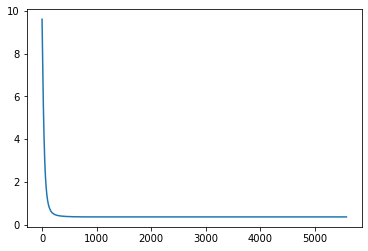

In [22]:
plot(losses)

In [23]:
res = odeint(neural_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, params, rtol=1e-5, atol=1e-5)

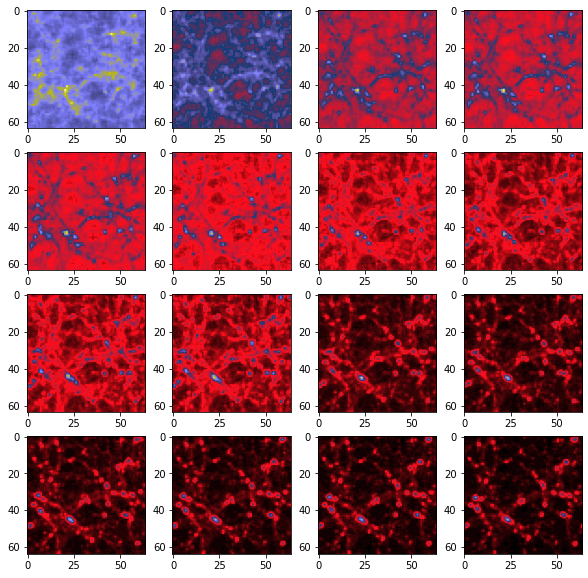

In [24]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), res[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [26]:
k, pk_ref = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_c = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), res[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

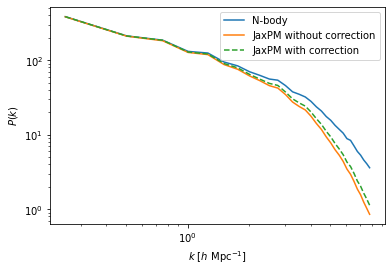

In [27]:
loglog(k, pk_ref, label='N-body')
loglog(k, pk_i, label='JaxPM without correction')
loglog(k, pk_c, '--', label='JaxPM with correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

In [30]:
for i, a in enumerate(scales[::2]): 
    k, pk_ref = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), poss[::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    k, pk_c = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), res[0][::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    semilogx(k, pk_c/pk_ref, color=col[i])
    
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")
plt.colorbar(sm, label='a')
plt.grid(True)
plt.ylim(0.,1.5)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


NameError: name 'col' is not defined

In [31]:
for i, a in enumerate(scales[::2]): 
    k, pk_ref = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), poss[::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    k, pk_i = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    semilogx(k, pk_i/pk_ref, color=col[i])
    
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")
plt.colorbar(sm, label='a')
plt.grid(True)
plt.ylim(0.,1.5)

NameError: name 'col' is not defined

In [ ]:
import pickle
pickle.dump( params, open( "camels_25_64_pos_vel.params", "wb" ) )